In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []
print("seed",seed)

print(datetime.datetime.now())

seed 3
2023-07-03 20:30:56.712167


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(-0.0260)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-7.9405)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(30.2243)
train_loss:  -5.465620297718049
valid_loss:  -3.7225428873538973
h_min_tilde -6.162122 ell_tilde -5.117004815645219 kappa_tilde 0.0009781772384848987
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -1.3540478993058205
valid_loss:  -0.466324645280838
weight_alpha 1.0 h_min_tilde -6.162122 ell_tilde -1.176503248500824 kappa_tilde 0.000447858145417756


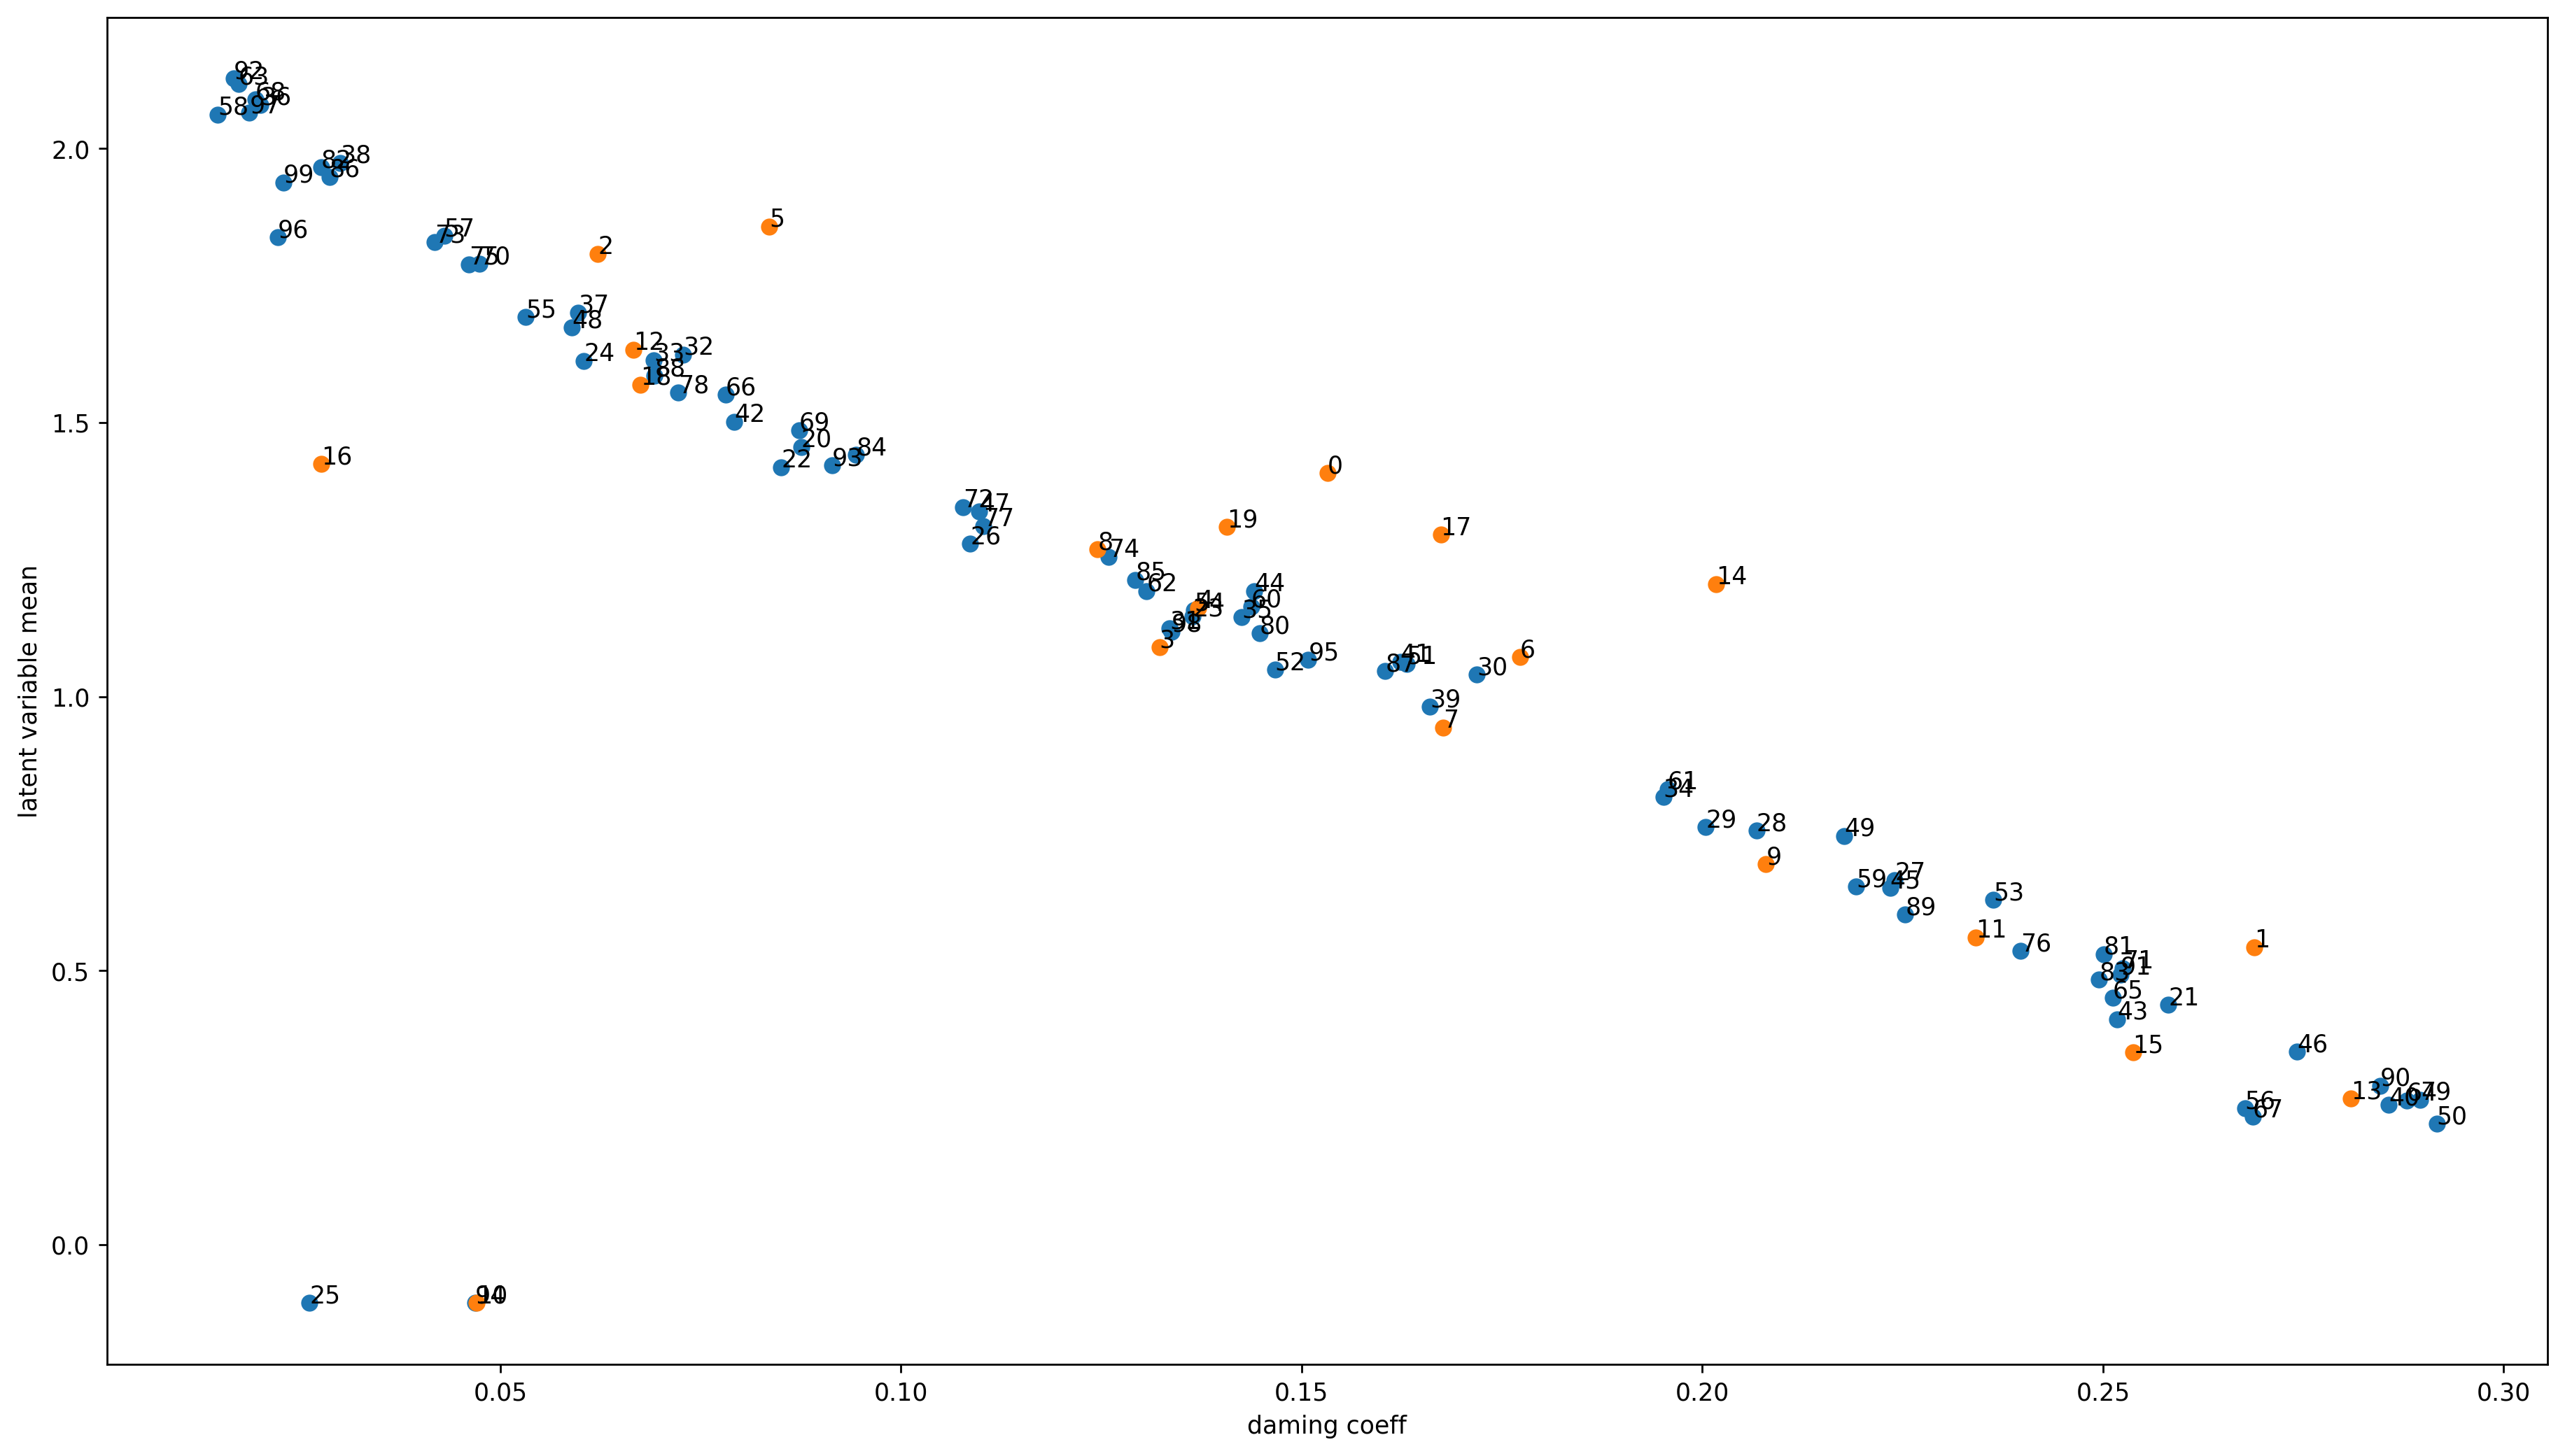

[0.15324828 0.26888793 0.06217286 0.13224295 0.13704997 0.08354618
 0.17725885 0.16765623 0.12453036 0.20794138]
[0.04706032 0.23409443 0.06658737 0.28091509 0.2017151  0.25372526
 0.0276651  0.16735223 0.06751635 0.14068207]
[0.08753783 0.25816017 0.08504636 0.13638662 0.06041361 0.02616881
 0.10865286 0.22402387 0.20675412 0.20044044]
[0.17183816 0.13354351 0.07280263 0.06917526 0.19514306 0.14252658
 0.02009083 0.05969281 0.0300313  0.16598332]
[0.28563037 0.1623059  0.079166   0.25175792 0.14407199 0.2234257
 0.27419258 0.10978218 0.05891417 0.21770089]
[0.29162951 0.1630783  0.14666197 0.23628546 0.13658381 0.05316401
 0.26771796 0.0429997  0.01473268 0.21921244]
[0.14369349 0.19566694 0.13065617 0.01731945 0.28791216 0.25123873
 0.07810352 0.2686711  0.01940196 0.08726173]
[0.0474101  0.25242589 0.10773226 0.04184014 0.12587483 0.04612206
 0.2396893  0.11031089 0.0721711  0.28956844]
[0.14474911 0.25010637 0.02763948 0.24952833 0.0943959  0.12924451
 0.02867004 0.16042046 0.06925

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.677786350250244

 2 3.8270554542541504

 3 3.678532361984253

 4 3.5754575729370117

 5 3.7064926624298096

 6 3.8015620708465576

 7 3.6678688526153564

 8 3.6887807846069336

 9 3.734206438064575

 10 3.8053414821624756

 11 3.80910587310791

 12 3.910477638244629

 13 3.8607938289642334

 14 3.9882616996765137

 15 3.8647964000701904

 16 3.952608823776245

 17 3.986159563064575

 18 3.845153331756592

 19 3.700544595718384

 20 3.762169361114502

 21 3.8368728160858154

 22 4.077038288116455

 23 3.8829503059387207

 24 3.885704278945923

 25 3.9243552684783936

 26 4.095125913619995

 27 3.983429431915283

 28 4.023606777191162

 29 3.8455491065979004

 30 3.856238603591919

 31 3.8122828006744385

 32 3.8613061904907227

 33 3.8654537200927734

 34 3.8841710090637207

 35 3.881403923034668

 36 3.9515740871429443

 37 4.11718225479126

 38 3.9886395931243896

 39 3.9219913482666016

 40 3.8811135292053223

 41 4.086655378341675

 42 4.040292501449585

 43 4.098217725753784


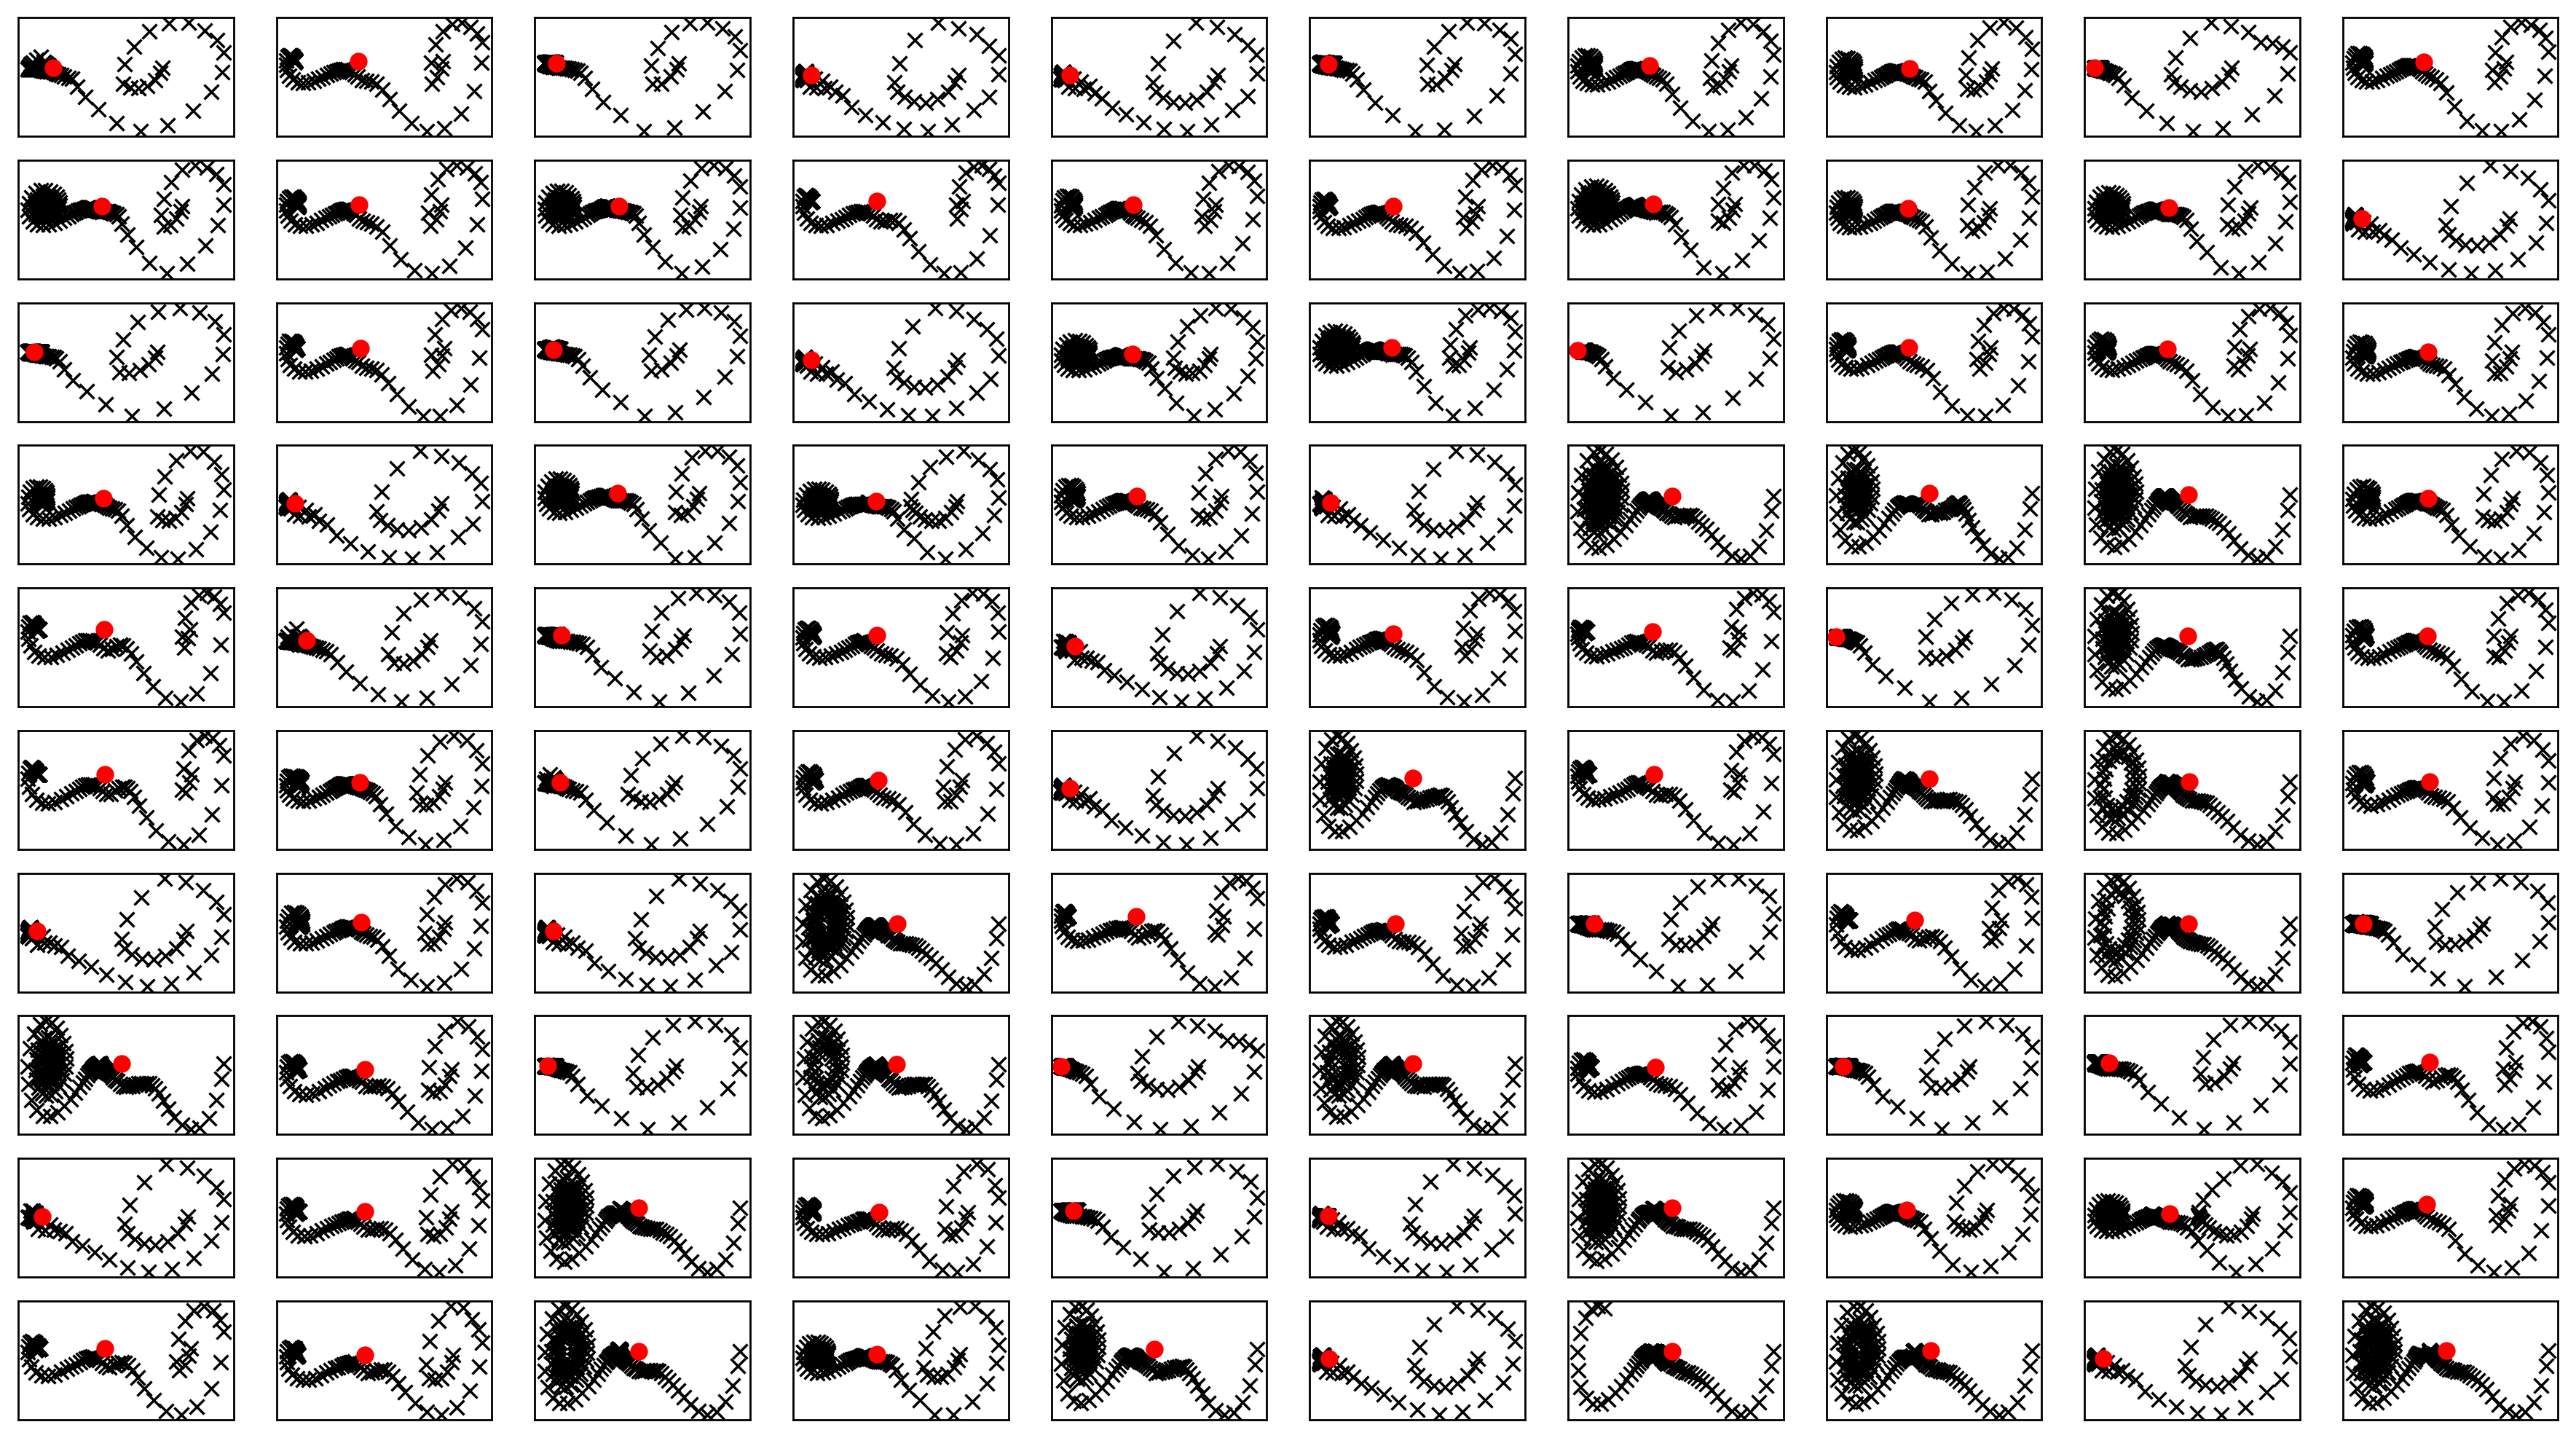

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 4.067643165588379

 2 4.178575754165649

 3 4.352539539337158

 4 4.1163856983184814

 5 4.129397630691528

 6 4.062839984893799

 7 4.148430109024048

 8 4.083621263504028

 9 4.1171040534973145

 10 4.135467290878296

 11 4.122845888137817

 12 4.117037057876587


In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())